<a href="https://colab.research.google.com/github/IdanC1s2/RL_Beginner2Master/blob/main/Section_3_policy_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align:center">
    <h1>
        Policy Iteration
    </h1>
</div>
<br>

<div style="text-align:center">
    <p>
        In this notebook we are going to look at a dynamic programming algorithm called policy iteration. In it, we will iteratively interleave two processes: policy evaluation and policy improvement, until the optimal policy and state values are found.
    </p>
</div>

<br>

In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)



## Import the necessary software libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize the environment

In [3]:
env = Maze()

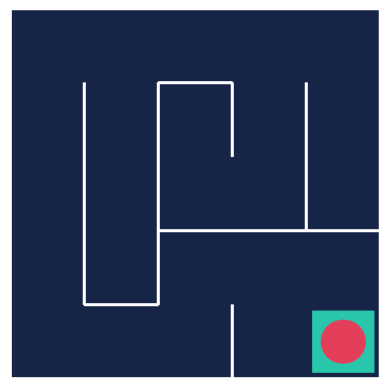

In [4]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [5]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [6]:
policy_probs = np.full((5, 5, 4), 0.25)

In [7]:
def policy(state):
  return policy_probs[state]

#### Test the policy with state (0, 0)

In [8]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

In [ ]:
test_agent(env, policy, episodes=1)

#### Plot the policy

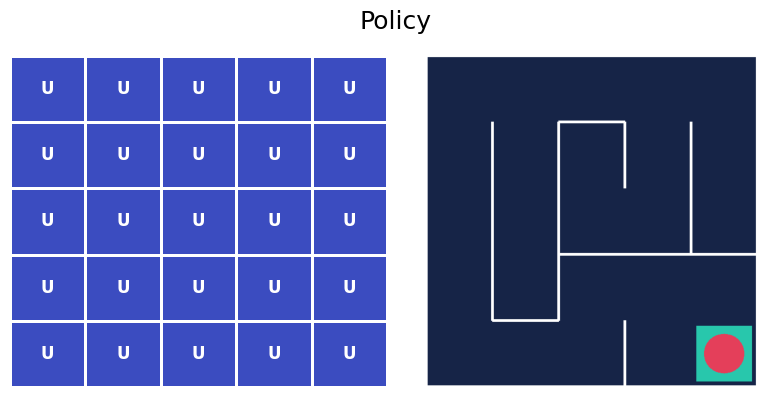

In [9]:
plot_policy(policy_probs, frame)

## Define value table $V(s)$

#### Create the $V(s)$ table

In [10]:
state_values = np.zeros(shape=(5,5))

#### Plot V(s)

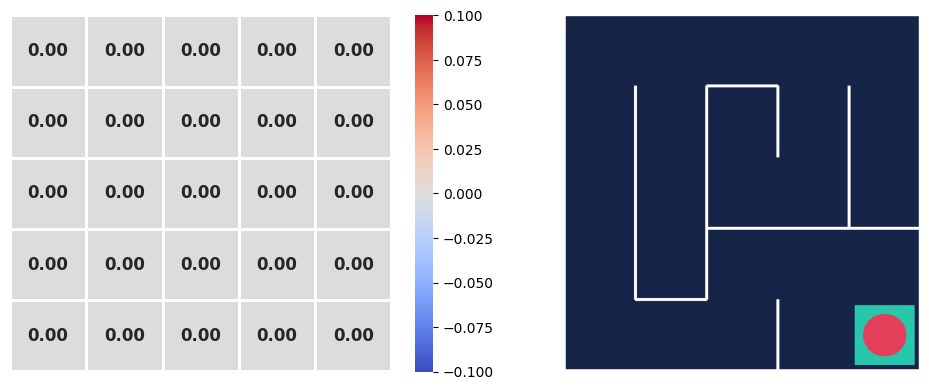

In [11]:
plot_values(state_values, frame)

## Implement the Policy Iteration algorithm

In [12]:
# Initilaize V(s):
def reset_Vs(size):
  Vs = np.zeros([size, size])
  return Vs

size = 5
Vs = reset_Vs(size)

For Visualizing the Policy Iteration Process:


In [13]:
# from IPython import display, clear_output
from IPython.display import display, clear_output
from time import sleep

class Vs_interactive_visualizer():

  def __init__(self,Vs):
    self.cur_state = Vs
    self.fig, self.ax = plt.subplots(1)
    plt.title("V(s) - Heatmap")
    # plt.close(self.fig)

    self.sz = Vs.shape[0]

  def update_state(self, Vs):
    self.cur_state = Vs

  def update_visual(self, policy_eval_iter, policy_impr_iter):
    self.ax.clear()  # Clear previous annotations
    self.cax = self.ax.matshow(Vs, cmap='autumn')


    clear_output(wait=True)

    for i in range(self.sz):
      for j in range(self.sz):
          plt.annotate(str(f'{self.cur_state[i,j]:.2f}'), xy=(j, i),
                      ha='center', va='center', color='white')


    # Redraw the figure
    self.ax.set_title(f'Policy Iteration {policy_impr_iter}\nPolicy Evaluation Iteration {policy_eval_iter}')

    self.fig.canvas.draw()


    # Display the updated figure
    print(self.fig)
    display(self.fig)



In [ ]:
# delta = 0
# env.reset()
# Vs = reset_Vs(size)
# gamma = 1

# state = (4,3)
# # state = (i,j)
# Vs_old = Vs[state]
# reward_vec_a = np.zeros([n_acts])
# for act_id, action in enumerate(env.action_space.action_meanings.keys()):
#   new_state, r, _, _ = env.simulate_step(state=state, action=action)
#   print(f'new state: {new_state}')
#   print(f'state reward: {r}')

#   reward_vec_a[act_id] = r + gamma * Vs[new_state]
#   print(f'reward_vec_a={reward_vec_a}')



# print(f'policy(state)={policy(state)}')
# Vs[state] = np.dot(policy(state), reward_vec_a)
# print(f'Vs[state] = {Vs[state]}')
# delta = np.max([delta, np.abs(Vs_old - Vs[state])])
# print(f'new delta = {delta}')

new state: (3, 3)
state reward: -1.0
reward_vec_a=[-1.  0.  0.  0.]
new state: (4, 4)
state reward: -1.0
reward_vec_a=[-1. -1.  0.  0.]
new state: (4, 3)
state reward: -1.0
reward_vec_a=[-1. -1. -1.  0.]
new state: (4, 3)
state reward: -1.0
reward_vec_a=[-1. -1. -1. -1.]
policy(state)=[0.25 0.25 0.25 0.25]
Vs[state] = -1.0
new delta=1.0


Figure(640x480)


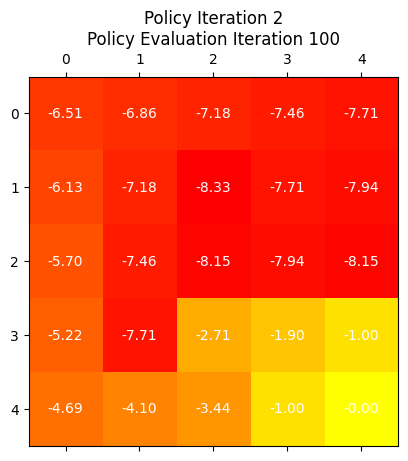

Policy Improvement Stage (No. 2)
Policy_stable=True


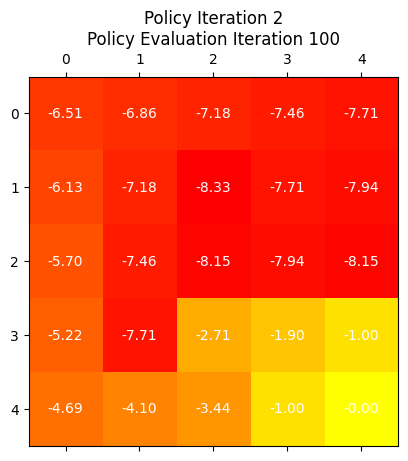

In [20]:
def policy_improvement(env, policy_probs, Vs, gamma):
  size = 5
  policy_stable = True
  n_acts = len(env.action_space.action_meanings)

  for i in range(size):
    for j in range(size):
      # print(f'state={state}')
      state = (i,j)
      old_action = np.argmax(policy_probs[state])

      act_rewards = np.zeros(n_acts)
      for act in env.action_space.action_meanings.keys():


        new_state, r, _, _ = env.simulate_step(state=state, action=act)
        act_rewards[act] = r + gamma * Vs[new_state]

      best_act = np.argmax(act_rewards)

      if old_action != best_act:
        policy_stable = False


      policy_probs[state] = np.zeros(n_acts)
      policy_probs[state[0],state[1], best_act] = 1.

  # print(f'Policy is', '' if policy_stable else 'not', 'stable')
  print(f'Policy_stable={policy_stable}')

  return policy_stable


def policy_evaluation(env, Vs, delta, tol, gamma, vis_params=None):
  if vis_params is not None:
    update_every = vis_params['update_every']
    counter_impr = vis_params['counter_impr']
    counter_eval = vis_params['counter_eval']
  size = 5
  n_acts = len(env.action_space.action_meanings)
  while delta > tol:
    delta = 0

    for i in range(size):
      for j in range(size):

        state = (i,j)

        Vs_old = Vs[state]
        reward_vec_a = np.zeros([n_acts])
        for act_id, action in enumerate(env.action_space.action_meanings.keys()):
          new_state, r, _, _ = env.simulate_step(state=state, action=action)
          reward_vec_a[act_id] = r + gamma * Vs[new_state]

        Vs[state] = np.dot(policy(state), reward_vec_a)
        delta = np.max([delta, np.abs(Vs_old - Vs[state])])
        # print(f'delta={delta}')

    if not counter_eval % update_every:
      Vs_vis.update_state(Vs)
      Vs_vis.update_visual(policy_eval_iter=counter_eval, policy_impr_iter=counter_impr)
      sleep(1)
    counter_eval +=1

  return



policy_probs = np.full((5, 5, 4), 0.25)
Vs = reset_Vs(size)
gamma = 0.9
tol = 1e-5
policy_stable = False
delta = 100
env.reset()
update_every = 100
vis_params = {}
vis_params['update_every'] = 10
vis_params['counter_impr'] = 1
Vs_vis = Vs_interactive_visualizer(Vs)  # Set an animation visualizing the state values in each iteration

while not policy_stable:
  print(f'policy iteration={vis_params["counter_impr"]}')
  vis_params['counter_eval'] = 1


  # Policy Evaluation
  print(f'Policy Evaluation Stage')
  policy_evaluation(env, Vs, delta, tol, gamma, vis_params)

  # Policy Improvement
  print(f'Policy Improvement Stage (No. {vis_params["counter_impr"]})')
  policy_stable = policy_improvement(env, policy_probs, Vs, gamma)

  if vis_params['counter_impr'] > 20:  # Force stop after ___ policy improvements
    delta = 0
    policy_stable = True

  vis_params['counter_impr'] += 1



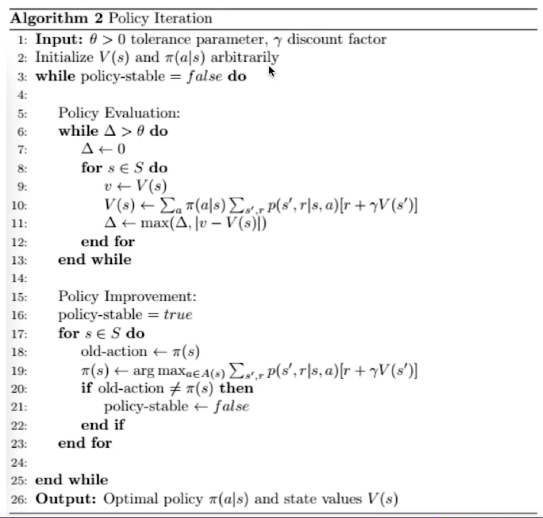

## Show results

Show resulting value table V(s)

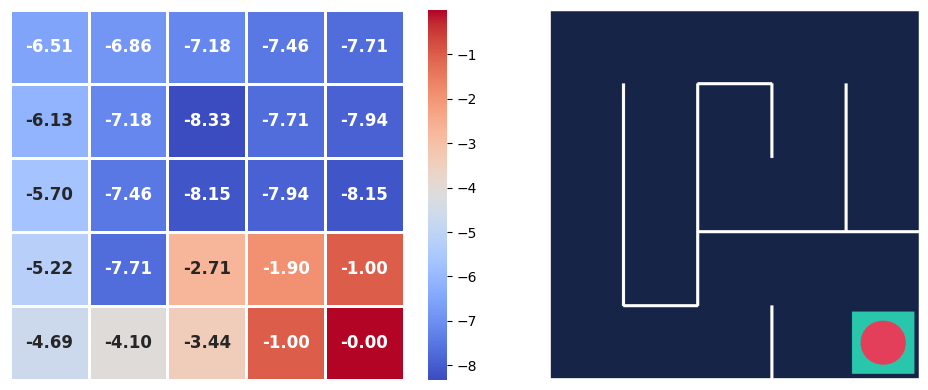

In [22]:
plot_values(Vs, frame)

Show resulting policy $\pi(\cdot|s)$

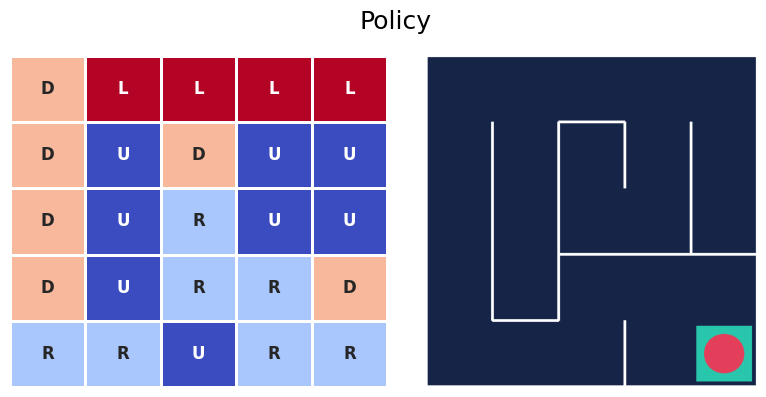

In [23]:
plot_policy(policy_probs, frame)

#### Test the resulting agent

In [56]:
test_agent(env, policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)